insert successfully
Naive method: 130ms
insert successfully
K-D tree: 0ms
Performance Visualization


/var/folders/p6/hq6ydbts4wn76fz0r7h_x9_c0000gn/T/ipykernel_73936/565953946.py:181: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


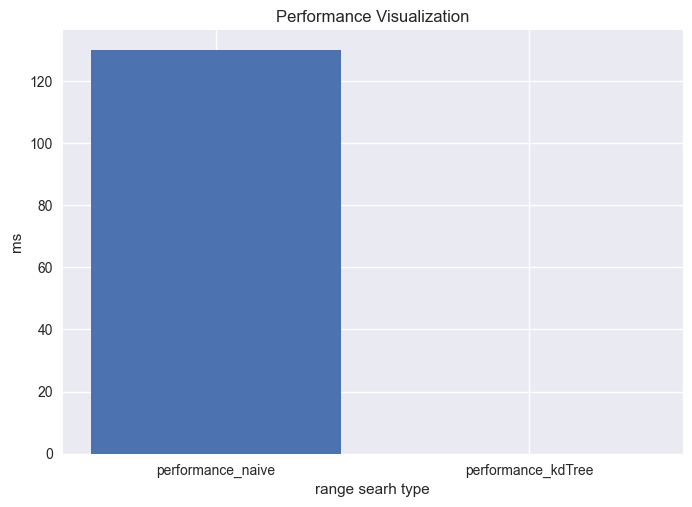

In [7]:
from typing import List
from collections import namedtuple
import time
import matplotlib.pyplot as plt
import numpy as np

class Point(namedtuple("Point", "x y")):
    def __repr__(self) -> str:
        return f'Point{tuple(self)!r}'


class Rectangle(namedtuple("Rectangle", "lower upper")):
    def __repr__(self) -> str:
        return f'Rectangle{tuple(self)!r}'

    def is_contains(self, p: Point) -> bool:
        return self.lower.x <= p.x <= self.upper.x and self.lower.y <= p.y <= self.upper.y


class Node(namedtuple("Node", "location left right")):
    """
    location: Point
    left: Node
    right: Node
    """

    def __repr__(self):
        return f'{tuple(self)!r}'


class KDTree:
    """k-d tree"""

    def __init__(self):
        self._root = None
        self._n = 0

    # At first, I didn't understand how to sort the namedtuple for a certain axis
    #  so I converted it to a dictionary and then sorted it.
    # sortX refers to sorting according to the x-axis
    # sortY is sorting according to the y-axis
    def sortX(self, p:List[Point]):
        points_dct = list()
        for Point in p:
            a = Point._asdict()
            dct = dict(a)
            points_dct.append(dct)
        points_dct = sorted(points_dct, key=lambda k:k['x'])
        points_xs = list()
        for i in points_dct:
            lis = list(i.values())
            pxs = Point._make(lis)
            points_xs.append(pxs)
        return points_xs
    
    def sortY(self, p:List[Point]):
        points_dct = list()
        for Point in p:
            a = Point._asdict()
            dct = dict(a)
            points_dct.append(dct)
        points_dct = sorted(points_dct, key=lambda k:k['y'])
        points_ys = list()
        for i in points_dct:
            lis = list(i.values())
            pys = Point._make(lis)
            points_ys.append(pys)
        return points_ys
    
    #After sorting according to a certain axis, find the midpoint, which is used to determine the root
    def find_midX(self, p:List[Point]):
        p = self.sortX(p)
        mid_x = p[len(p)//2]
        return mid_x
    
    def find_midY(self, p:List[Point]):
        p = self.sortY(p)
        mid_y = p[len(p)//2]
        return mid_y
    
    def insert(self, p: List[Point]):
        """insert a list of points"""
        # assume that the tree is empty, and we need to build a new one by the list
        def insert_counter(p:List[Point], count):
            if p is None:
                return None
            if p == []:
                return None
            elif count % 2 == 0:
                p = self.sortX(p)
                mid = self.find_midX(p)
            else:
                p = self.sortY(p)
                mid = self.find_midY(p)
            mid_index = len(p)//2
            return Node(mid, insert_counter(p[:mid_index],count+1),insert_counter(p[mid_index+1:],count+1))
            #In the inner return I designed a recursion. The middle point divides the list into two parts, the part smaller than the middle point should continue to be put into the left child of the node, and vice versa should be put into the right child, count times plus one and then again into the insert counter for the corresponding axis rearrangement, take the middle point and split the list this step, know the recursion to the last point to generate the node.
        self._root = insert_counter(p,0)
        print("insert successfully")
        return self
    
    def range(self, rectangle: Rectangle) -> List[Point]:
        """range query""" 
        in_range = []
        def range_counter(count,n:Node,r:Rectangle):
            sublist = []
            if n is None:
                sublist = []
            # Here a sublist is designed, and each recursion returns a sublist, 
            # which prevents the case of stopping the operation by directly returning none because a leaf is recurred to first,
            # and ensures that every leaf is recurred to.
            else:
                if r.is_contains(n[0]):
                    sublist.append(n[0])
                    sublist.extend(range_counter(count+1,n.left,r))
                    sublist.extend(range_counter(count+1,n.right,r))
    
                else:
                    if count%2 == 0: # The same counting idea as insert

                        # Explain the idea of exclusion here. 
                        # It is possible to omit the comparison of all points of a child of a node in some cases. 
                        # Suppose a node is out of range and will be compared for x. 
                        # Then when his x is less than the lower bound of a particular range, 
                        # the x of all points of his left child is less than the x of the node 
                        # and must be less than the lower bound of the range.

                        if n.location.x >= r.upper.x:
                            sublist.extend(range_counter(count+1,n.left,r))
                        elif n.location.x <= r.lower.x:
                            sublist.extend(range_counter(count+1,n.right,r))
                        else:
                            sublist.extend(range_counter(count+1,n.left,r))
                            sublist.extend(range_counter(count+1,n.right,r))

                    else:
                        if n.location.y >= r.upper.y:
                            sublist.extend(range_counter(count+1,n.left,r))
                        elif n.location.y <= r.lower.y:
                            sublist.extend(range_counter(count+1,n.right,r))  
                        else:
                            sublist.extend(range_counter(count+1,n.left,r))
                            sublist.extend(range_counter(count+1,n.right,r))
            return sublist
        in_range = range_counter(0,self._root,rectangle)         
        return in_range
    
def range_test():
    points = [Point(7, 2), Point(5, 4), Point(9, 6), Point(4, 7), Point(8, 1), Point(2, 3)]
    kd = KDTree()
    kd.insert(points)
    result = kd.range(Rectangle(Point(0, 0), Point(6, 6)))
    assert sorted(result) == sorted([Point(2, 3), Point(5, 4)])


def performance_test():
    points = [Point(x, y) for x in range(1000) for y in range(1000)]

    lower = Point(500, 500)
    upper = Point(504, 504)
    rectangle = Rectangle(lower, upper)
    #  naive method
    start = int(round(time.time() * 1000))
    result1 = [p for p in points if rectangle.is_contains(p)]
    end = int(round(time.time() * 1000))
    print(f'Naive method: {end - start}ms')
    naive = end - start
    kd = KDTree()
    kd.insert(points)
    # k-d tree
    start = int(round(time.time() * 1000))
    result2 = kd.range(rectangle)
    end = int(round(time.time() * 1000))
    print(f'K-D tree: {end - start}ms')
    kd_tree = end - start

    print('Performance Visualization')
    plt.title('Performance Visualization')
    plt.xlabel('range searh type')
    plt.ylabel('ms')
    plt.style.use('seaborn') 
    x = np.array(['performance_naive','performance_kdTree'])
    y = np.array([naive,kd_tree])
    plt.bar(x,y)
    plt.show()

    assert sorted(result1) == sorted(result2)



if __name__ == '__main__':
    range_test()
    performance_test()

In [ ]:
#### Unoriginal！！！！
# -*- coding:utf-8 -*-
import math
import numpy as np
from matplotlib import pyplot
from collections import Counter
import warnings


# k-Nearest Neighbor算法
def k_nearest_neighbors(data, predict, k=5):
    if len(data) >= k:
        warnings.warn("k is too small")
    # 计算predict点到各点的距离
    distances = []
    for group in data:
        for features in data[group]:
            # euclidean_distance = np.sqrt(np.sum((np.array(features)-np.array(predict))**2))   # 计算欧拉距离，这个方法没有下面一行代码快
            euclidean_distance = np.linalg.norm(np.array(features) - np.array(predict))
            distances.append([euclidean_distance, group])
    print(sorted(distances))
    sorted_distances = [i[1] for i in sorted(distances)]
    top_nearest = sorted_distances[:k]
    # print(top_nearest)  ['red','black','red']
    group_res = Counter(top_nearest).most_common(1)[0][0]
    confidence = Counter(top_nearest).most_common(1)[0][1] * 1.0 / k
    # confidences是对本次分类的确定程度，例如(red,red,red)，(red,red,black)都分为red组，但是前者显的更自信
    return group_res, confidence


if __name__ == '__main__':
    dataset = {'black': [[1, 2], [2, 3], [3, 1]], 'red': [[6, 5], [7, 7], [8, 6]]}
    new_features = [3.5, 5.2]  # 判断这个样本属于哪个组
    for i in dataset:
        for ii in dataset[i]:
            pyplot.scatter(ii[0], ii[1], s=50, color=i)

    which_group, confidence = k_nearest_neighbors(dataset, new_features, k=3)
    print(which_group, confidence)
    pyplot.scatter(new_features[0], new_features[1], s=100, color=which_group)
    pyplot.show()

